<a href="https://colab.research.google.com/github/TriPhan15/K-Means_K-NN/blob/main/K_Means_K_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import sys
import io

# Hàm hỗ trợ lấy dữ liệu
def get_data_input():
    print("\n--- CHỌN NGUỒN DỮ LIỆU ---")
    print("1. Tự sinh dữ liệu ngẫu nhiên (Random)")
    print("2. Tải file CSV từ máy tính (Colab Upload)")
    choice = input("Chọn (1 hoặc 2): ")

    if choice == '1':
        return 'random', None
    elif choice == '2':
        print("\nVui lòng chọn file CSV từ máy tính...")
        try:
            from google.colab import files
            uploaded = files.upload()
            if not uploaded:
                return None, None
            filename = next(iter(uploaded))
            # Đọc file bằng pandas
            df = pd.read_csv(io.BytesIO(uploaded[filename]))
            print(f"Đã tải file: {filename}")
            print(df.head())

            # Lấy 2 cột đầu làm features
            X = df.iloc[:, :2].values
            # Lấy cột 3 làm label (nếu có)
            y = df.iloc[:, 2].values if df.shape[1] > 2 else None
            return 'file', (X, y)

        except ImportError:
            print("Lỗi: Không thể dùng tính năng upload ngoài Colab.")
            return None, None
        except Exception as e:
            print(f"Lỗi đọc file: {e}")
            return None, None
    else:
        return None, None

In [15]:
class KMeansClustering:
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.centers = None
        self.labels = None

    def init_centers(self, X):
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]

    def assign_labels(self, X, centers):
        D = cdist(X, centers)
        return np.argmin(D, axis=1)

    def update_centers(self, X, labels):
        centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            Xk = X[labels == k, :]
            if len(Xk) > 0:
                centers[k, :] = np.mean(Xk, axis=0)
            else:
                centers[k, :] = self.centers[k, :]
        return centers

    def has_converged(self, old_centers, new_centers):
        return (set([tuple(a) for a in old_centers]) ==
                set([tuple(a) for a in new_centers]))

    def fit(self, X):
        print(f"\n--- BẮT ĐẦU HUẤN LUYỆN K-MEANS (K={self.n_clusters}) ---")
        self.centers = self.init_centers(X)
        self.labels = np.zeros(X.shape[0])

        for i in range(self.max_iter):
            print(f"\n>> Bước lặp {i+1}:")
            old_centers = self.centers
            self.labels = self.assign_labels(X, self.centers)
            self.centers = self.update_centers(X, self.labels)

            print(f"   Vị trí tâm cũ: \n{np.round(old_centers, 2)}")
            print(f"   Vị trí tâm mới: \n{np.round(self.centers, 2)}")

            if self.has_converged(old_centers, self.centers):
                print(f"-> K-Means đã hội tụ sau {i+1} bước.")
                break
        print("--------------------------------------------------")

    def plot_result(self, X):
        plt.figure(figsize=(8, 6))
        plt.title(f'Kết quả K-Means với K={self.n_clusters}')
        plt.scatter(X[:, 0], X[:, 1], c=self.labels, s=50, cmap='viridis', label='Data Points', alpha=0.6)
        plt.scatter(self.centers[:, 0], self.centers[:, 1], c='red', s=200, marker='X', label='Centroids')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

In [16]:
class KNNClassifier:
    def __init__(self, k=3):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X_test, verbose=False):
        num_test = X_test.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            distances = np.sqrt(np.sum((self.X_train - X_test[i, :])**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            k_nearest_dists = distances[k_indices]

            if verbose:
                print(f"\n>> Đang phân loại điểm {X_test[i]}:")
                print(f"   {self.k} láng giềng gần nhất có index: {k_indices}")
                print(f"   Khoảng cách tương ứng: {np.round(k_nearest_dists, 2)}")
                print(f"   Nhãn của láng giềng: {k_nearest_labels}")

            counts = np.bincount(k_nearest_labels.astype(int))
            y_pred[i] = np.argmax(counts)

            if verbose:
                print(f"-> Kết quả bầu chọn: Class {int(y_pred[i])}")
        return y_pred

    def plot_result(self, X_test, y_pred, point_new=None):
        plt.figure(figsize=(8, 6))
        plt.title(f'Kết quả phân loại K-NN với K={self.k}')
        plt.scatter(self.X_train[:, 0], self.X_train[:, 1], c=self.y_train, s=50, cmap='viridis', alpha=0.6, label='Training Data')

        if point_new is not None:
            plt.scatter(point_new[:, 0], point_new[:, 1], c='red', s=200, marker='*', label='New Point')
            plt.annotate(f"Dự đoán: Lớp {int(y_pred[0])}",
                         (point_new[0,0], point_new[0,1]),
                         xytext=(15,15), textcoords='offset points',
                         bbox=dict(boxstyle="round", fc="w"))

        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

--- K-MEANS ---

--- CHỌN NGUỒN DỮ LIỆU ---
1. Tự sinh dữ liệu ngẫu nhiên (Random)
2. Tải file CSV từ máy tính (Colab Upload)
Chọn (1 hoặc 2): 2

Vui lòng chọn file CSV từ máy tính...


Saving K_NN-K_Means.csv to K_NN-K_Means (4).csv
Đã tải file: K_NN-K_Means (4).csv
     x    y  label
0  1.5  2.5      0
1  1.0  3.0      0
2  2.0  2.0      0
3  1.8  2.8      0
4  8.5  8.0      1
Nhập số cụm K muốn chia (ví dụ 3): 3

--- BẮT ĐẦU HUẤN LUYỆN K-MEANS (K=3) ---

>> Bước lặp 1:
   Vị trí tâm cũ: 
[[7.5 2.5]
 [8.  9. ]
 [9.  2. ]]
   Vị trí tâm mới: 
[[3.63 2.47]
 [8.43 8.57]
 [8.75 1.75]]

>> Bước lặp 2:
   Vị trí tâm cũ: 
[[3.63 2.47]
 [8.43 8.57]
 [8.75 1.75]]
   Vị trí tâm mới: 
[[1.58 2.58]
 [8.43 8.57]
 [8.25 2.  ]]

>> Bước lặp 3:
   Vị trí tâm cũ: 
[[1.58 2.58]
 [8.43 8.57]
 [8.25 2.  ]]
   Vị trí tâm mới: 
[[1.58 2.58]
 [8.43 8.57]
 [8.25 2.  ]]
-> K-Means đã hội tụ sau 3 bước.
--------------------------------------------------


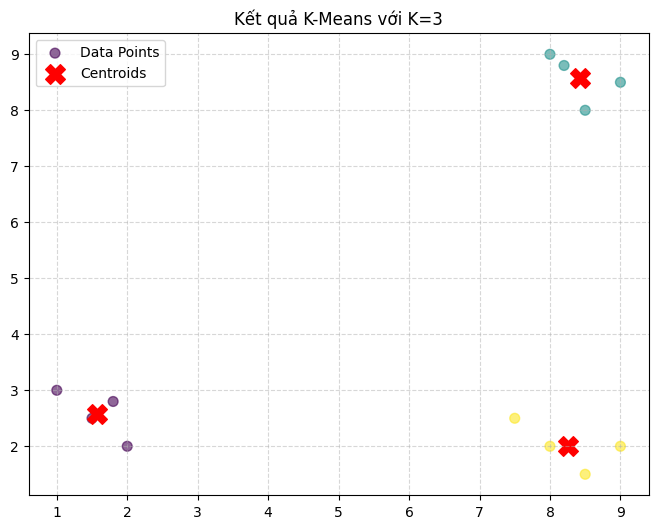

In [18]:
# === CELL CHẠY K-MEANS ===
print("--- K-MEANS ---")
source, data = get_data_input()

if source:
    if source == 'random':
        print("Đang tạo dữ liệu ngẫu nhiên...")
        X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.8, random_state=42)
    elif source == 'file':
        X, _ = data

    try:
        k_input = int(input("Nhập số cụm K muốn chia (ví dụ 3): "))
        model = KMeansClustering(n_clusters=k_input)
        model.fit(X)
        model.plot_result(X)
    except ValueError:
        print("Lỗi nhập liệu! Vui lòng chạy lại cell này.")
else:
    print("Bạn chưa chọn dữ liệu. Hãy chạy lại cell.")

--- K-NN ---

--- CHỌN NGUỒN DỮ LIỆU ---
1. Tự sinh dữ liệu ngẫu nhiên (Random)
2. Tải file CSV từ máy tính (Colab Upload)
Chọn (1 hoặc 2): 2

Vui lòng chọn file CSV từ máy tính...


Saving K_NN-K_Means.csv to K_NN-K_Means (5).csv
Đã tải file: K_NN-K_Means (5).csv
     x    y  label
0  1.5  2.5      0
1  1.0  3.0      0
2  2.0  2.0      0
3  1.8  2.8      0
4  8.5  8.0      1
Nhập số láng giềng K (ví dụ 3): 3

--- NHẬP ĐIỂM CẦN DỰ ĐOÁN ---
Nhập x: 10
Nhập y: 2

>> Đang phân loại điểm [10.  2.]:
   3 láng giềng gần nhất có index: [4 0 5]
   Khoảng cách tương ứng: [1.   2.   6.18]
   Nhãn của láng giềng: [2 2 1]
-> Kết quả bầu chọn: Class 2


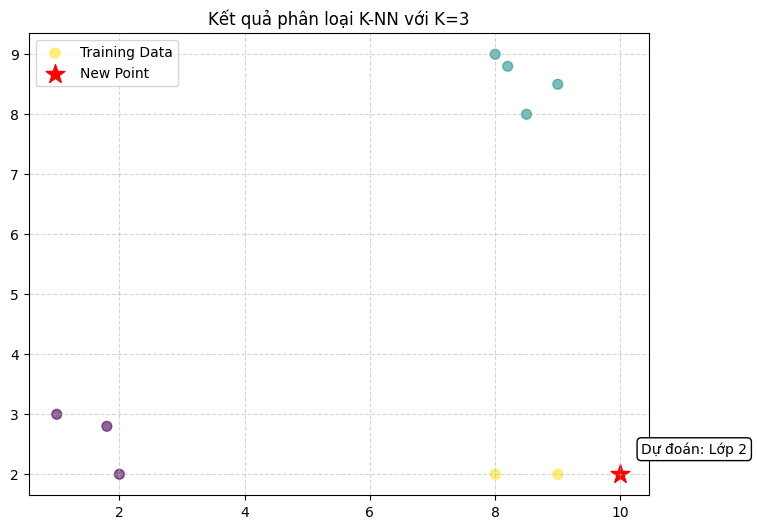

In [19]:
# === CELL CHẠY K-NN ===
print("--- K-NN ---")
source, data = get_data_input()

if source:
    if source == 'random':
        X, y = make_blobs(n_samples=200, centers=3, cluster_std=1.0, random_state=42)
    elif source == 'file':
        X, y = data
        if y is None:
            print("Lỗi: File CSV không có cột nhãn (Label)!")
            X = None # Reset để không chạy tiếp

    if X is not None:
        # Chia train/test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        try:
            k_input = int(input("Nhập số láng giềng K (ví dụ 3): "))
            knn = KNNClassifier(k=k_input)
            knn.fit(X_train, y_train)

            print("\n--- NHẬP ĐIỂM CẦN DỰ ĐOÁN ---")
            x_coord = float(input("Nhập x: "))
            y_coord = float(input("Nhập y: "))
            new_point = np.array([[x_coord, y_coord]])

            prediction = knn.predict(new_point, verbose=True)
            knn.plot_result(X_test, prediction, point_new=new_point)

        except ValueError:
            print("Lỗi nhập liệu! Vui lòng chạy lại cell này.")
else:
    print("Bạn chưa chọn dữ liệu.")